In [1]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

from astropy import units as u
from astropy import constants as c

%matplotlib inline

In [2]:
sns.set_style('darkgrid')

## Constants

In [3]:
# cgs units
solMass   = (1 * u.solMass).cgs.value
jupMass   = (2 * u.jupiterMass).cgs.value
earthMass = (1 * u.earthMass).cgs.value
G         = (1 * c.G).cgs.value
AU        = (1 * u.au).cgs.value
year      = (1 * u.year).cgs.value
day       = (1 * u.day).cgs.value

## Derivatives

Calculates velocity and acceleration on $m_i$ due to $m_j$ and $m_k$

In [4]:
def sho_func(t, uin_i, m_j, uin_j, m_k, uin_k):
    # position and velocity
    r_i = uin_i[:2]
    v_i = uin_i[2:]
    
    r_j = uin_j[:2]
    r_k = uin_k[:2] 
    # position vector pointing from one of the two masses to m_i
    d_ij = np.linalg.norm(r_j - r_i)
    d_ik = np.linalg.norm(r_k - r_i)

    # calulating accelerations
    g = (G*m_j/d_ij**3) * (r_j - r_i) + (G*m_k/d_ik**3) * (r_k - r_i)
    
    derivs = np.ndarray(4)
    derivs[:2] = v_i
    derivs[2:] = g
    
    return derivs

## Integrator

In [5]:
def sho_RK4(t, uold_i, m_j, uold_j, m_k, uold_k, dt):
    K1 = sho_func(t, uold_i, m_j, uold_j, m_k, uold_k)
    K2 = sho_func(t + dt/2, uold_i + K1*dt/2, m_j, uold_j, m_k, uold_k)
    K3 = sho_func(t + dt/2, uold_i + K2*dt/2, m_j, uold_j, m_k, uold_k)
    K4 = sho_func(t + dt, uold_i + K3*dt, m_j, uold_j, m_k, uold_k)
    
    unew_i = uold_i + (dt/6)*(K1 + 2*(K2 + K3) + K4)
    return unew_i

### Initial Conditions

$q \equiv m_3 / m_2$

In [74]:
q   = 0.1
m_1 = solMass # host star
m_2 = jupMass #m_1 / 5000 # hot jupiter
m_3 = q * m_2  # companion

# m1 (host star)
x_1  =  0.0
y_1  =  0.1
vx_1 =  0.0
vy_1 =  0.0

# m2 (hot jupiter)
x_2  = -0.02 * AU
y_2  =  0.1
vx_2 =  0.0
vy_2 = -np.sqrt(G*m_1/np.abs(x_2))

# m3 (companion)
x_3  = x_2 
y_3  =  - 38.44E9
vx_3 =  0.0
vy_3 = vy_2 # relative to m_2

T0 = 2*np.pi*np.sqrt(np.abs(x_2)**3/(G*m_1))
tmax  = T0 / 2

uold_1 = np.array( [x_1, y_1, vx_1, vy_1] )
uold_2 = np.array( [x_2, y_2, vx_2, vy_2] )
uold_3 = np.array( [x_3, y_3, vx_3, vy_3] )

m1_coord = uold_1
m2_coord = uold_2
m3_coord = uold_3

t = 0
while (t <= tmax):
    # v0 based on speed at beginning of current timestep
    f = -1
    r0 = np.sqrt( (uold_3[0] - uold_2[0])**2 + (uold_3[1] - uold_2[1])**2 )
    v0 = np.sqrt(uold_3[2]**2 + uold_3[3]**2) 
    dt = 10**(f) * r0 / v0
    
    unew_1 = sho_RK4(t, uold_1, m_2, uold_2, m_3, uold_3, dt) # sun
    unew_2 = sho_RK4(t, uold_2, m_1, uold_1, m_3, uold_3, dt) # earth
    unew_3 = sho_RK4(t, uold_3, m_1, uold_1, m_2, uold_2, dt) # moon
    
    m1_coord = np.vstack( (m1_coord, unew_1) )
    m2_coord = np.vstack( (m2_coord, unew_2) )
    m3_coord = np.vstack( (m3_coord, unew_3) )
    
    # step forward
    uold_1 = unew_1 
    uold_2 = unew_2
    uold_3 = unew_3
    t += dt

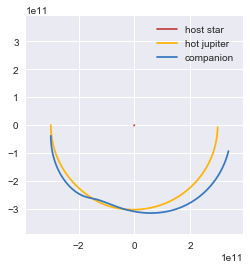

In [88]:
fig, ax = plt.subplots(1,1)

colors = ["reddish", "amber", "windows blue"]#, "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

ax.set_aspect("equal")

x_1 = m1_coord[:,0]
y_1 = m1_coord[:,1]
x_2 = m2_coord[:,0]
y_2 = m2_coord[:,1]
x_3 = m3_coord[:,0]
y_3 = m3_coord[:,1]

ax.plot(x_1, y_1, label='host star')
ax.plot(x_2, y_2, label='hot jupiter')
ax.plot(x_3, y_3, label='companion')

#ax.plot(x_3[100]/AU, y_3[100]/AU, 'ro')

lim = 1.3*np.abs(x_2[0])
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.legend()

plt.show()

In [64]:
m1_list[:][3]

array([ -4.68087111e+05,  -8.68559278e+03,  -1.70466647e+03,
        -4.13400791e+01])

# Animate

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
fig, ax = plt.subplots()
lim = 1
ax.set_xlim((-lim, lim))
ax.set_ylim((-lim, lim))

line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
line = [line, line2, line3]

# initialization function: plot the background of each frame
def init():
    line[0].set_data([], [])
    line[1].set_data([], [])
    line[2].set_data([], [])
    return line

# animation function. This is called sequentially
def animate(i):
   # plot the trajectory
    line[0].set_data(x_2[:i+1] / AU, y_2[:i+1] / AU) 
    # the +1 makes it inclusive
    line[0].set_color('orange')
    
    # add a point at the beginning
    line[1].set_data(x_2[0] / AU, y_2[0] / AU)
    line[1].set_marker('o')
    line[1].set_color('g')
    
    # add a point at the end
    line[2].set_data(x_2[i] / AU, y_2[i] / AU)
    line[2].set_marker('o')
    line[2].set_color('r')
    
    return line

In [ ]:
# call the animator. blit=True re-draws just the parts that have 
# changed to make things a bit faster

# remove white margin
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, 
                    wspace=None, hspace=None)
N = len(x_2)
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int(N), interval=50, blit=True)
HTML(anim.to_html5_video())